# 의료 영상 진단기 성능 개선
흉부 X-ray 이미지를 보고 폐렴을 진단하는 모델을 만들어본다.

## Rubric

|평가문항|상세기준|
|:---|:---|
|1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
|2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|
|3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.|

## Contents

1. Set-up
2. 데이터 가져오기
3. 데이터 시각화
4. CNN 모델링
5. 클래스 불균형 처리
6. 모델 훈련
7. 결과 확인
8. 정확도 향상 시키기
    - Data Augmentation
    - Handling Imbalance
    - Hyper Parameter Tuning
    - Enable/disable Batch Normalization, Dropout
9. 프로젝트 정리

## 1.Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


성능 향상을 위해 조정해 볼수 있는 하이퍼파라미터에는 BATCH_SIZE, EPOCHS이 있다.

__Batch size가 SGD에 끼치는 영향__

|Large Batch|Smal Batch|
|:---|:---|
|<ol>▶ Accurate estimate of the gradient (low variance)</ol><ol>▶ High computation cost per iteration</ol><ol>▶ High availability of parallelism</ol>|<ol>▶ Noisy estimate of the gradient (high variance)</ol><ol>▶ Low computation cost per iteration</ol><ol>▶ Low availability of parallelism (slow training)</ol>|


## 2. 데이터 가져오기

- 데이터 셋

[Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) :
중국 광저우 1~5세 소아 환자의 흉부 X선 영상

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print("# of train:",len(train_filenames))
print("# of test:",len(test_filenames))
print("# of val:",len(val_filenames))

# of train: 5216
# of test: 624
# of val: 16


### Train, Validation 데이터 재분배

val 개수가 너무 적기때문에 train에서 val에 쓰일 데이터를 가져온다.
train과 val에 있는 데이터를 모은 다음에 train:val을 80:20으로 분할한다.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


### class 별 데이터 비율 확인
- Normal과 Pneumonia 데이터의 비율을 확인한다.

train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 확인해본다.

In [5]:
# 정상 이미지와 폐렴 이미지를 구분해야 하는데
# 다행히도 파일 경로에 힌트가 있어요
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0627-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person569_bacteria_2360.jpeg


In [6]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


결과를 보면 폐렴 이미지 수가 정상 이미지 보다 3배 가량 더 많이 있다. CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 학습이 더 잘되기 때문에 차후 불균형을 조정해야 한다.

### Tensor Dataset 생성

tf.data 인스턴스를 생성한다. tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 효율적으로 할 수 있도록 해준다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


파일경로에 있는 'NORMAL'과 'PNEUMONIA'를 이용하여 라벨 데이터를 만들어준다.

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 사이즈를 통일시키고 gpu 메모리를 더욱 효율적으로 사용하기위해 이미지 사이즈를 줄여봅시다.

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 분리

In [11]:
# num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해 줍니다.
train_dataset = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_dataset = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

이미지 사이즈와, 라벨 확인

In [12]:
for image, label in train_dataset.take(1): # 하나의 데이터만 가져온다
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


train, validation과 같은 방법으로 test 데이터 셋도 만들어준다.

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH) # tf.data 인스턴스를 생성
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해준다.
아래 함수는 train 데이터 셋을 효율적으로 사용할 수 있도록 변환시켜 준다.



In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # shuffle(): 고정 크기 버퍼를 유지, 해당 버퍼에서 무작위로 균일하게 다음 요소 선택
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat(): epoch를 진행하면서 여러 번 데이터셋을 불러와 사용하게 해준다
    ds = ds.repeat()
    # BATCH_SIZE에서 정한 만큼의 배치
    ds = ds.batch(BATCH_SIZE)
    # prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에 리소스의 유휴 상태를 줄일 수 있다
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_dataset)
val_ds = prepare_for_training(val_dataset)

## 3. 데이터 시각화

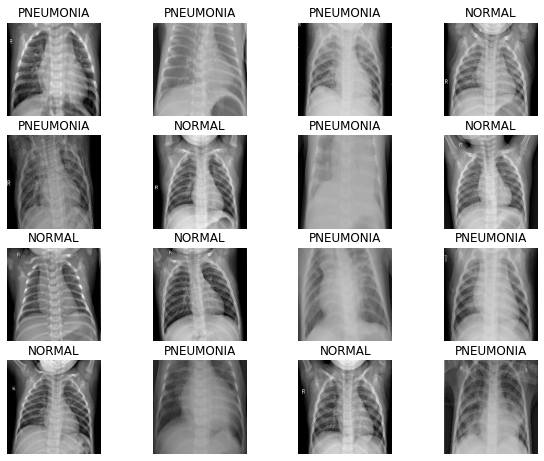

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링

### Convolution Block 생성
- Convolution을 두 번 진행하고
- Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결
- Max Pooling

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

### Dense Block

- Batch Normalization
- Dropout

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

Dense Block에는 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용된다.

 일반적으로 이런 방법은 잘 사용되지 않거나 금기시된다.
variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용되는것이 어울리지 않는다는 [논문](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf)이 그 예이다.

그러나, 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 [경우](https://arxiv.org/pdf/1905.05928.pdf)도 있어,
이번 실습에서는 두가지를 함께 사용하는 모델이 성능 향상에 도움이 될지 여부도 흥미롭게 살펴볼 부분이다.

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 클래스 불균형 처리

>__Weight balancing__<br>
training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. 

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련

In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 58s 141ms/step - loss: 0.5450 - accuracy: 0.7116 - precision: 0.9144 - recall: 0.6802 - val_loss: 0.7099 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 35s 136ms/step - loss: 0.2306 - accuracy: 0.9104 - precision: 0.9780 - recall: 0.9002 - val_loss: 1.2514 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 35s 136ms/step - loss: 0.2034 - accuracy: 0.9222 - precision: 0.9780 - recall: 0.9161 - val_loss: 0.3106 - val_accuracy: 0.8413 - val_precision: 0.8226 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 36s 137ms/step - loss: 0.1907 - accuracy: 0.9271 - precision: 0.9760 - recall: 0.9255 - val_loss: 0.5767 - val_accuracy: 0.7962 - val_precision: 1.0000 - val_recall: 0.7225
Epoch 5/25
261/261 [==============================] - 36s 137ms/step - loss: 0.1702 - accura

## 7. 결과 확인

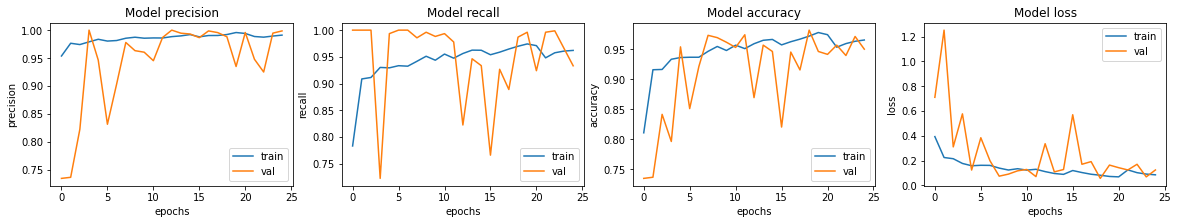

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 73ms/step - loss: 0.5651 - accuracy: 0.8750 - precision: 0.8498 - recall: 0.9718
Loss: 0.5651074051856995,
Accuracy: 0.875,
Precision: 0.8497757911682129,
Recall: 0.971794843673706


## 8. 정확도 향상 시키기

1. Data Augmentation
2. Handling Imbalance
3. Hyper Parameter Tuning
4. Enable/disable Batch Normalization, Dropout

In [44]:
history_normal = attempt()                          # 기본값
history_optimizer = attempt(OPTIMIZER='sgd')        # Optimizer SGD로 변경
history_batch = attempt(BATCH_SIZE=8)               # Batch size 8로 변경
history_epochs = attempt(EPOCHS=40)                 # epoch 40으로 변경
history_augmentation = attempt(AUGMENTATION=True)  # Augmentation 실시
history_weight = attempt(CLASS_WEIGHT=False)  # Augmentation 실시
attempt_ndo_normal = attempt_ndo()                # Drop out 제거
history_nbn_normal = attempt_nbn()                # BatchNormalization 제거
history_nbnndo_normal = attempt_nbnndo()       # BatchNormalization, Drop out제거 

Epoch 1/25
261/261 [==============================] - 44s 139ms/step - loss: 0.5060 - accuracy: 0.7532 - precision: 0.9285 - recall: 0.7226 - val_loss: 0.7166 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 35s 135ms/step - loss: 0.2425 - accuracy: 0.9046 - precision: 0.9741 - recall: 0.8961 - val_loss: 1.5736 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 35s 136ms/step - loss: 0.2164 - accuracy: 0.9232 - precision: 0.9763 - recall: 0.9198 - val_loss: 0.4811 - val_accuracy: 0.7865 - val_precision: 0.7751 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 35s 136ms/step - loss: 0.1629 - accuracy: 0.9411 - precision: 0.9873 - recall: 0.9342 - val_loss: 0.1028 - val_accuracy: 0.9644 - val_precision: 0.9879 - val_recall: 0.9634
Epoch 5/25
261/261 [==============================] - 36s 136ms/step - loss: 0.1662 - accura

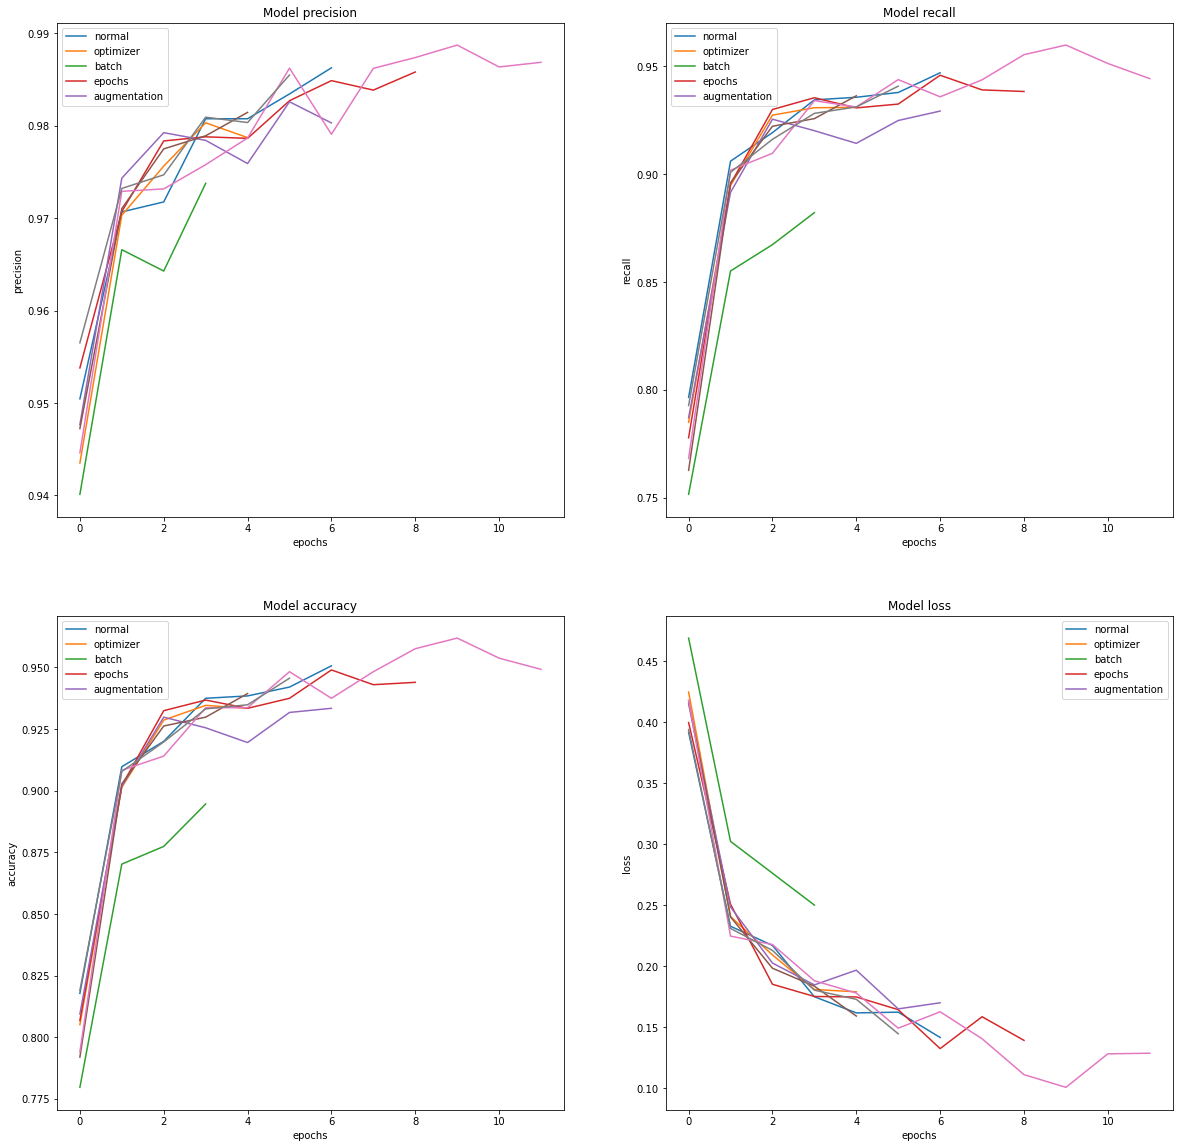

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax = ax.ravel()

history_list = [history_normal, history_optimizer, history_batch, history_epochs, history_augmentation, attempt_ndo_normal,history_nbn_normal,history_nbnndo_normal ]
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    for history in history_list:
        ax[i].plot(history[0].history[met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['normal', 'optimizer', 'batch', 'epochs', 'augmentation'])

In [63]:
history_names = ['history_normal', 'history_optimizer', 'history_batch', 'history_epochs', 'history_augmentation', 'attempt_ndo_normal','history_nbn_normal','history_nbnndo_normal' ]
for name, history in zip(history_names, history_list):
    print(name)
    print('Loss: ',history[1]['Loss'])
    print('Accuracy: ',history[1]['Accuracy'])
    print('Precision: ',history[1]['Precision'])
    print('Recall: ', history[1]['Recall'])
    print('='*80)

history_normal
Loss:  0.5309158563613892
Accuracy:  0.8349359035491943
Precision:  0.8021052479743958
Recall:  0.9769230484962463
history_optimizer
Loss:  0.4775657057762146
Accuracy:  0.7644230723381042
Precision:  0.7296786308288574
Recall:  0.9897435903549194
history_batch
Loss:  0.2918696105480194
Accuracy:  0.875
Precision:  0.8679245114326477
Recall:  0.9435897469520569
history_epochs
Loss:  0.4388176500797272
Accuracy:  0.8589743375778198
Precision:  0.8647342920303345
Recall:  0.9179487228393555
history_augmentation
Loss:  0.40511372685432434
Accuracy:  0.8557692170143127
Precision:  0.8712871074676514
Recall:  0.9025641083717346
attempt_ndo_normal
Loss:  0.7534320950508118
Accuracy:  0.8157051205635071
Precision:  0.7858628034591675
Recall:  0.9692307710647583
history_nbn_normal
Loss:  0.8675770163536072
Accuracy:  0.7387820482254028
Precision:  0.7052441239356995
Recall:  1.0
history_nbnndo_normal
Loss:  0.44788268208503723
Accuracy:  0.8541666865348816
Precision:  0.83900225

의료영상 판독은 Recall이 중요한 성능지표인데, Accuracy가 비교적 낮은 편인데도 Recall 높은 수치를 기록하는 경우도 있다.batch nomalization을 제거한 모델 결과를 보면 정확도는 0.74 정도지만 Recall은 1.0이다. 
그래도 Accuracy가 0.85 이상인 모델은 Recall도 높은 편이기 때문에 두 지표를 고려하여 적절한 모델을 선택해야 할 것같다.

하지만 이번 프로젝트 루브릭에서는 Accuracy를 높이는 것이니, Accuracy 0.85 이상인 조합으로 돌려보자!

- Batch Size: 8
- Epoch: 40 (Early stopping, val loss 기준으로 2번이상 증가하면 멈춤)
- Augmentation: 좌우반전 이미지 증강
- 레이어 안에 Batch Normalization, Drop out 제거

In [72]:
history_combination = attempt_nbnndo(BATCH_SIZE=8, EPOCHS=40, AUGMENTATION=True) 

Epoch 1/40
523/523 [==============================] - 48s 77ms/step - loss: 0.6479 - accuracy: 0.6639 - precision: 0.8684 - recall: 0.6445 - val_loss: 1.4751 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/40
523/523 [==============================] - 40s 76ms/step - loss: 0.3583 - accuracy: 0.8444 - precision: 0.9516 - recall: 0.8344 - val_loss: 0.4509 - val_accuracy: 0.8212 - val_precision: 0.9983 - val_recall: 0.7585
Epoch 3/40
523/523 [==============================] - 40s 76ms/step - loss: 0.2881 - accuracy: 0.8726 - precision: 0.9662 - recall: 0.8601 - val_loss: 0.5890 - val_accuracy: 0.8087 - val_precision: 0.7948 - val_recall: 0.9974
Epoch 4/40
523/523 [==============================] - 40s 77ms/step - loss: 0.2761 - accuracy: 0.8780 - precision: 0.9650 - recall: 0.8676 - val_loss: 0.2783 - val_accuracy: 0.9067 - val_precision: 0.9218 - val_recall: 0.9543
Epoch 5/40
523/523 [==============================] - 40s 77ms/step - loss: 0.2985 - accuracy: 0

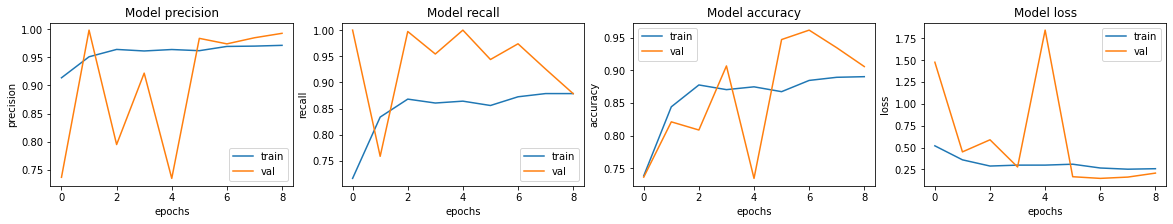

In [73]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_combination[0].history[met])
    ax[i].plot(history_combination[0].history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [74]:
history_combination[1]

{'Loss': 0.5309601426124573,
 'Accuracy': 0.8333333134651184,
 'Precision': 0.824999988079071,
 'Recall': 0.9307692050933838}

기본 베이스라인의 Accuracy와 비슷한 수치를 보이는데 Recall은 더 떨어졌다..

***

## 프로젝트 정리

- 이번 프로젝트는 의료영상 이미지 분류를 접해보는 것과 모델을 구성하는 여러 조건들을 조정해보며 모델의 성능을 향상 시키는게 주 내용이었다.
-  Batch Normalization과 Dropout이라는 두 가지 regularization 기법을 사용 했을 때 성능이 올라가는 경우를 확인해 봤는데, 둘 다 적용했을 때 Accuracy 0.83 정도의 수치가 나왔고, Dropout만 적용했을 때는 0,73, Batch Normalization만을 적용했을 때 0.81, 모두 적용하지 않았을 때는 0.85의 수치가 나왔다.
- 기법을 적용하지 않았을 경우에 좋은 결과를 보고나니 뭐든 적재적소에 잘 사용하는게 중요하다는 것을 다시 한번 깨달을 수 있었다.
- 모델의 성능을 높일 수 있는 경우의 수는 굉장히 많은데  어제 세미나에서 들었던 것처럼 어떤 문제와 데이터에는 어떤 모델이 필요하다. 라는 경험적, 지식적 체계를 가져야 한다는 생각이 들었다.
